In [90]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [80]:
#mps : Metal Performance Shaders => Mac에서 cuda 대신 GPU 활용하는 방법

print(torch.__version__)
print(torch.backends.mps.is_built())
print(torch.backends.mps.is_available())

mps_device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

2.6.0
True
True


In [82]:
transform = transforms.ToTensor()

# train data, test data 가져오기 : CIFAR-10 dataset

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

In [52]:
print(trainset, testset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor() Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [54]:
trainset[0][0].shape

torch.Size([3, 32, 32])

In [56]:
trainset[0][1]

6

In [66]:
# 정확도를 측정하는 함수, 정확도 plot 그리는 함수

def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(mps_device), labels.to(mps_device)

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1, marker='.')
  plt.plot(x, test_accs, label=label2, marker='v')
  plt.legend()
  plt.show()

In [68]:
# 심화 과제 batch size = 256
batch_size = 256

# trainset, testset에 대한 dataloader
# trainset은 shuffle=True, testset은 shuffle=False
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [70]:
from torch import nn

# 모델1 정의 
# 활성화 함수 - LeakyReLU, 최적화 알고리즘 - Adam vs SGD
class Model1(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)
    # CIFAR-10도 10개의 클래스를 분류됨.

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x

In [104]:
from torch.optim import SGD, Adam

# 조건 정의 (input 차원, learning rate, epoch 수, batch size)
input_dim = 32 * 32 *3
lr = 0.001
n_epochs = 50
batch_size = 256
loss_fn = nn.CrossEntropyLoss()

# 1-1 : activation_fn = leakyReLU, optimization_fn = Adam
model = Model1(input_dim, 1024)
model = model.to(mps_device)

optimizer = Adam(model.parameters(), lr=lr)

# 이전 commit에서 학습 방법을 비교하라고 해서 train 결과만 저장
train_adam = []
test_adam = []

# 학습 부분
for epoch in range(n_epochs):
    total_loss = 0. # 0은 정수형, 0.은 실수형
    model.train()
    
    for data in trainloader:
        model.zero_grad() # 기울기 초기화 : 이전 commit에서 optimizer.zero_grad를 한 것이 잘못됨
        inputs, labels = data
        inputs, labels = inputs.to(mps_device), labels.to(mps_device)

        preds = model(inputs)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    model.eval()
    train_adam.append(accuracy(model, trainloader))
    test_adam.append(accuracy(model, testloader))

    print(f'[Epoch {epoch+1}] Loss: {total_loss:.4f}')      

[Epoch 1] Loss: 444.0784
[Epoch 2] Loss: 399.4407
[Epoch 3] Loss: 373.1488
[Epoch 4] Loss: 359.6215
[Epoch 5] Loss: 347.4771
[Epoch 6] Loss: 336.9570
[Epoch 7] Loss: 329.2467
[Epoch 8] Loss: 321.8158
[Epoch 9] Loss: 314.5348
[Epoch 10] Loss: 309.5111
[Epoch 11] Loss: 304.3071
[Epoch 12] Loss: 299.4943
[Epoch 13] Loss: 295.6317
[Epoch 14] Loss: 290.9050
[Epoch 15] Loss: 287.2915
[Epoch 16] Loss: 283.5460
[Epoch 17] Loss: 280.0355
[Epoch 18] Loss: 276.1308
[Epoch 19] Loss: 273.0666
[Epoch 20] Loss: 270.3677
[Epoch 21] Loss: 267.5450
[Epoch 22] Loss: 263.7296
[Epoch 23] Loss: 259.4421
[Epoch 24] Loss: 258.1308
[Epoch 25] Loss: 254.8792
[Epoch 26] Loss: 251.6459
[Epoch 27] Loss: 252.7971
[Epoch 28] Loss: 245.7280
[Epoch 29] Loss: 245.8609
[Epoch 30] Loss: 240.7876
[Epoch 31] Loss: 240.4249
[Epoch 32] Loss: 234.2471
[Epoch 33] Loss: 232.0690
[Epoch 34] Loss: 228.8540
[Epoch 35] Loss: 228.9591
[Epoch 36] Loss: 223.9665
[Epoch 37] Loss: 221.0478
[Epoch 38] Loss: 219.6362
[Epoch 39] Loss: 214.

In [106]:
# 1-2 : activation_fn = leakyReLU, optimization_fn = SGD
model = Model1(input_dim, 1024)
model = model.to(mps_device)

optimizer = SGD(model.parameters(), lr=lr)

train_sgd = []
test_sgd = []

for epoch in range(n_epochs):
    total_loss = 0.
    model.train()
    
    for data in trainloader: 
        model.zero_grad() # optimizer.zero_grad()는 가중치를 업데이트할 때, 이전 단계에서 계산된 기울기를 초기화
        inputs, labels = data
        inputs, labels = inputs.to(mps_device), labels.to(mps_device)

        preds = model(inputs)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    model.eval()
    train_sgd.append(accuracy(model, trainloader))
    test_sgd.append(accuracy(model, testloader))

    print(f'[Epoch {epoch+1}] Loss: {total_loss:.4f}')

[Epoch 1] Loss: 450.7745
[Epoch 2] Loss: 449.6396
[Epoch 3] Loss: 448.6584
[Epoch 4] Loss: 447.5848
[Epoch 5] Loss: 446.5185
[Epoch 6] Loss: 445.4295
[Epoch 7] Loss: 444.3415
[Epoch 8] Loss: 443.2301
[Epoch 9] Loss: 442.0725
[Epoch 10] Loss: 440.9281
[Epoch 11] Loss: 439.7599
[Epoch 12] Loss: 438.5846
[Epoch 13] Loss: 437.4051
[Epoch 14] Loss: 436.2305
[Epoch 15] Loss: 435.0266
[Epoch 16] Loss: 433.8475
[Epoch 17] Loss: 432.4163
[Epoch 18] Loss: 430.8945
[Epoch 19] Loss: 429.4860
[Epoch 20] Loss: 428.0315
[Epoch 21] Loss: 426.6348
[Epoch 22] Loss: 425.3258
[Epoch 23] Loss: 424.0238
[Epoch 24] Loss: 422.7919
[Epoch 25] Loss: 421.5302
[Epoch 26] Loss: 420.3903
[Epoch 27] Loss: 419.1603
[Epoch 28] Loss: 418.1016
[Epoch 29] Loss: 417.0710
[Epoch 30] Loss: 416.0391
[Epoch 31] Loss: 415.1342
[Epoch 32] Loss: 414.1774
[Epoch 33] Loss: 413.2228
[Epoch 34] Loss: 412.3644
[Epoch 35] Loss: 411.5742
[Epoch 36] Loss: 410.6974
[Epoch 37] Loss: 409.9751
[Epoch 38] Loss: 409.1152
[Epoch 39] Loss: 408.

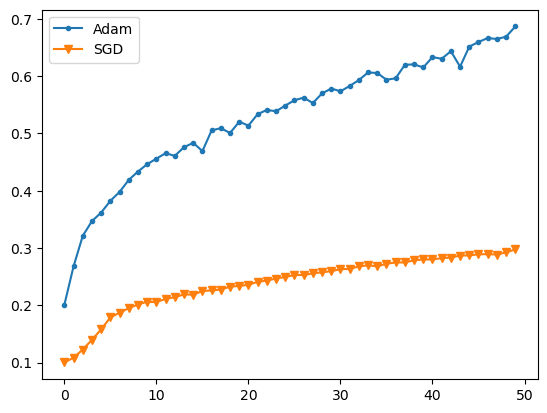

In [108]:
# Adam vs SGD plot
plot_acc(train_adam, train_sgd, label1='Adam', label2='SGD')

In [110]:
# 모델2 정의 
# 활성화 함수가 Sigmoid인 함수

class Model2(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10) # CIFAR-10도 10개의 클래스를 분류됨.

    self.act = nn.Sigmoid()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x

In [112]:
model = Model2(input_dim, 1024)
model = model.to(mps_device)

optimizer = Adam(model.parameters(), lr=lr)

train_sigmoid = []
test_sigmoid = []

for epoch in range(n_epochs):
    total_loss = 0.
    model.train()

    for data in trainloader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to(mps_device), labels.to(mps_device)

        preds = model(inputs)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    model.eval()
    train_sigmoid.append(accuracy(model, trainloader))
    test_sigmoid.append(accuracy(model, testloader))

    print(f'Epoch {epoch+1} | Loss: {total_loss}')

Epoch 1 | Loss: 410.0066010951996
Epoch 2 | Loss: 392.792613863945
Epoch 3 | Loss: 386.14186358451843
Epoch 4 | Loss: 383.0258477926254
Epoch 5 | Loss: 380.93307399749756
Epoch 6 | Loss: 378.88577675819397
Epoch 7 | Loss: 377.08891701698303
Epoch 8 | Loss: 375.2056608200073
Epoch 9 | Loss: 374.65802025794983
Epoch 10 | Loss: 373.29251205921173
Epoch 11 | Loss: 371.89250671863556
Epoch 12 | Loss: 370.4140502214432
Epoch 13 | Loss: 369.88353431224823
Epoch 14 | Loss: 368.14142417907715
Epoch 15 | Loss: 368.15977144241333
Epoch 16 | Loss: 367.3411740064621
Epoch 17 | Loss: 366.75631403923035
Epoch 18 | Loss: 365.2132796049118
Epoch 19 | Loss: 365.2082223892212
Epoch 20 | Loss: 363.8473187685013
Epoch 21 | Loss: 364.1440632343292
Epoch 22 | Loss: 363.3236926794052
Epoch 23 | Loss: 362.163498044014
Epoch 24 | Loss: 361.89390194416046
Epoch 25 | Loss: 361.44207870960236
Epoch 26 | Loss: 361.1454402208328
Epoch 27 | Loss: 359.6447949409485
Epoch 28 | Loss: 359.10205006599426
Epoch 29 | Loss: 

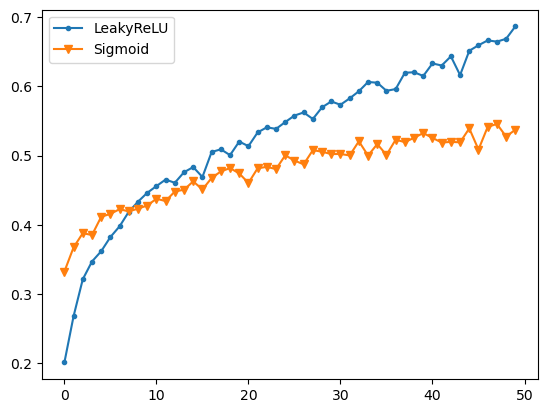

In [114]:
# 활성화함수 LeakyReLU vs Sigmoid (optimizer는 Adam으로 동일)
# LeakyReLU, Adam은 train_adam (Model 1-1)

plot_acc(train_adam, train_sigmoid, 'LeakyReLU', 'Sigmoid')

In [120]:
# 모델3 정의 : dropout

class Model3(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    # 활성화 함수 : LeaklyReLU
    self.act = nn.LeakyReLU()
    self.dropout = nn.Dropout(p=0.1) # 이전 commmit에서 nn.Dropout(0.1)로 표기함

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.dropout(self.act(self.layer1(x)))
    x = self.dropout(self.act(self.layer2(x)))
    x = self.dropout(self.act(self.layer3(x)))

    return x

In [124]:
model = Model3(input_dim, 1024)
model = model.to(mps_device)

optimizer = Adam(model.parameters(), lr=lr)

train_dropout = []
test_dropout = []

for epoch in range(n_epochs):
    total_loss = 0.
    model.train()

    for data in trainloader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to(mps_device), labels.to(mps_device)

        preds = model(inputs)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    with torch.no_grad():
        model.eval()
        train_dropout.append(accuracy(model, trainloader))
        test_dropout.append(accuracy(model, testloader))

    print(f'Epoch {epoch+1} | Loss: {total_loss}')

Epoch 1 | Loss: 446.70842957496643
Epoch 2 | Loss: 421.22250485420227
Epoch 3 | Loss: 412.2731521129608
Epoch 4 | Loss: 408.0995123386383
Epoch 5 | Loss: 395.44731080532074
Epoch 6 | Loss: 389.5311527252197
Epoch 7 | Loss: 386.26933693885803
Epoch 8 | Loss: 382.85549223423004
Epoch 9 | Loss: 378.10286343097687
Epoch 10 | Loss: 374.1387372016907
Epoch 11 | Loss: 370.0852988958359
Epoch 12 | Loss: 365.35282814502716
Epoch 13 | Loss: 362.5723465681076
Epoch 14 | Loss: 361.8124680519104
Epoch 15 | Loss: 358.8830473423004
Epoch 16 | Loss: 355.86633932590485
Epoch 17 | Loss: 352.8170573711395
Epoch 18 | Loss: 350.82784163951874
Epoch 19 | Loss: 348.8360333442688
Epoch 20 | Loss: 345.944508433342
Epoch 21 | Loss: 344.89486598968506
Epoch 22 | Loss: 343.50141966342926
Epoch 23 | Loss: 340.9025493860245
Epoch 24 | Loss: 337.089590549469
Epoch 25 | Loss: 337.54388976097107
Epoch 26 | Loss: 337.2268351316452
Epoch 27 | Loss: 333.85799074172974
Epoch 28 | Loss: 332.44728446006775
Epoch 29 | Loss: 

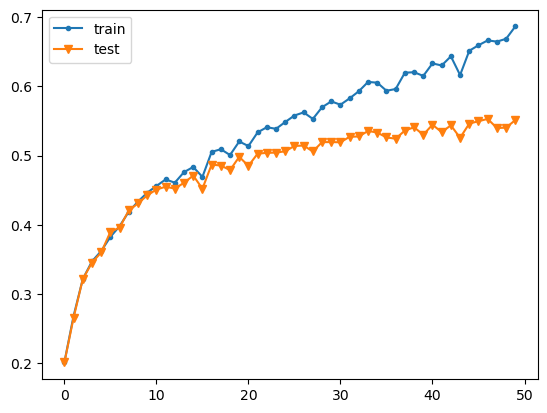

In [126]:
 plot_acc(train_adam, test_adam, 'train', 'test')

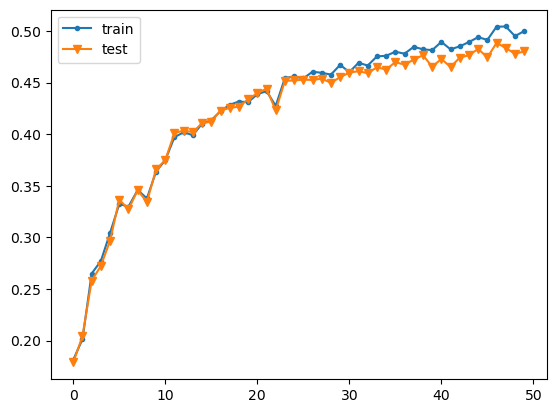

In [128]:
plot_acc(train_dropout, test_dropout)